# PHYS 6260: Homework 4, C. Michael Haynes

In [1]:
# generic list of import statements to not have to keep track
import numpy as np
from scipy import constants
import math as m
import warnings
import os

# importing specific to animation formalism found in the template notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'html5' # this is used to display animations in jupyter notebooks

from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings( "ignore")

## Problem 1
### One-dimensional advection
The advection equation for a quantity $q$ is given in 1D by
$$ \partial_t q + c \partial_x q = 0 \qquad . $$

Here, $c$ is the wave speed. Our goal is to implement the FTCS and FTUS numerical schemes to solve this equation over a specified domain in one dimension. The parameters are specified as follows.

Domain: $x\in [0,1]\,\mathrm{m}$

Speed: $c = 1 \,\mathrm{m} \,\mathrm{s}^{-1} $

Initial value: $q(x) = 1\,\mathrm{kg} \, \mathrm{m}^{-3}$ for $x\in[0.3,0.6]$ and  $q(x) = 0.1\,\mathrm{kg}\, \mathrm{m}^{-3}$ everywhere else. The discretization scheme for FTCS with the 1D, first order advection equation reads:

$$ q_i^{n+1} = q_i^{n} + \frac{c \mathrm{d}t}{2\mathrm{d}x} (q^n_{i+1} - q^n_{i-1} ) \qquad .$$

The quantity $q$ represents a density advecting via wave transport. 

#### (a) FTCS (Forward-time, Centered-spatial) Integration method

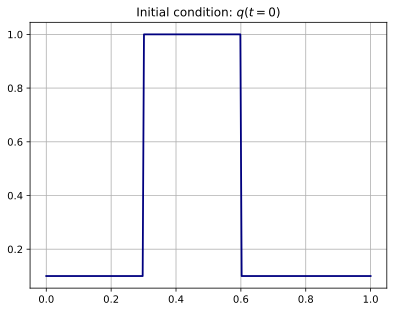

CFL factor = 0.024900000000000002


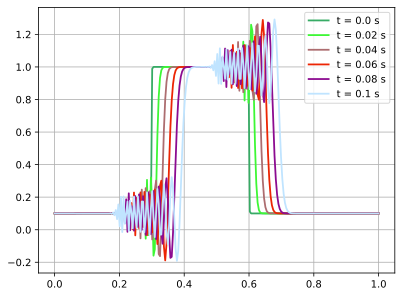

In [2]:
# initialize time and spatial meshes
xmin = 0.
xmax = 1.
Npoints = 250

tmax = 0.1
dt = 1.e-04
nt = tmax / dt

# initialize spatial grid 
x_arr = np.linspace(start=xmin,stop=xmax,num=Npoints)
dx = x_arr[2] - x_arr[1]

color_arr = ['#37AB65', '#3DF735', '#AD6D70', '#EC2504', '#8C0B90', '#C0E4FF', '#27B502', '#7C60A8', '#CF95D7', '#FF9900']

# define wave speed
c = 1.

cfl_factor = c * dt / dx

# define function to advance density array
def advance_FTCS(q_arr, cfl_factor):
    N = len(q_arr)
    ret_arr = np.zeros_like(q_arr)
    #ret_arr[1:N-1] = q_arr[1:N-1] + cfl_factor * ( q_arr[2:N] + q_arr[0:N-2] - 2.*q_arr[1:N-1])
    ret_arr[1:N-1] = q_arr[1:N-1] - (cfl_factor/2.) * ( q_arr[2:N] - q_arr[0:N-2])
    return ret_arr

def init_advec1D(x_arr):
    ret_arr = np.ones_like(x_arr)
    for i in range(len(ret_arr)):
        if x_arr[i] < 0.3 or x_arr[i] > 0.6:
            ret_arr[i] = 0.1
        else:
            continue
    return ret_arr


# initialize density profile
q0 = init_advec1D(x_arr)
q_n = q0
q_np1 = np.zeros_like(q_n)

plt.plot(x_arr,q0,color='navy',linewidth=1.8)
plt.grid()
plt.title('Initial condition: $q(t=0)$')
plt.show()
print('CFL factor = '+str(cfl_factor))


# initialize time markers for loop
time = 0.
time_idx=0
ticker = 0

while time_idx <= nt:
    
    q_np1 = advance_FTCS(q_n, cfl_factor)
    q_np1[0] = q_np1[-1] = 0.1
    
    if time_idx % 200 == 0:
        teq = 't = '
        lab = teq + str(round(time,4)) + ' s'
        plt.plot(x_arr, q_np1, color=color_arr[ticker % len(color_arr)],linewidth=1.8,label=lab)
        #print(lab)
        ticker+= 1


    q_n = q_np1.copy()
    q_np1 = np.zeros_like(q_n)
    
    time += dt
    time_idx += 1


plt.grid()
plt.legend()
plt.show()


Here, we can clearly see the noise is developing in our solution for the density $q$. We iterate the solution further in time to visualize the full descent into noise. The FTCS method is unconditionally unstable for all choices of the Courant number, following a growth $g(k)$ that (for wavenumber $k$, from Von Neumann stability analysis) satisfies:
$$ |g(k)|^2 = 1 + \frac{c^2 \mathrm{d}t^2}{\mathrm{d}x^2} \sin^2{k\mathrm{d}x} \qquad .$$
This implies that the solution will diverge regardless of the choice of numerical grid spacings. It is interesting to notice that the noise is largely produced around the regions with steep gradients in density: i.e., at $x=0.3$ meters or $x=0.6$ meters. However, the noise will eventually compund everywhere on the domain until it begins to dominate the initial signal, and consequently the solution will appear formless.

The development and propagation of numerical noise might be contributed to by our choice for the boundary conditions: since it was not specified for problem 1(a), we decided to fix the boundary values at $q=0.1\,\mathrm{kg}\,\mathrm{m}^{-3}$. The noise is clearly exaggerated once the propagating (and heavily oscillatory) waveform reaches the right boundary. 

We can illustrate this further by evolving the system for a full second: 

In [3]:
# initialize time and spatial meshes
xmin = 0.
xmax = 1.
Npoints = 250

tmax = 0.5
dt = 1.e-04
nt = tmax / dt

save_every1 = int(1e2)

# initialize spatial grid 
x_arr = np.linspace(start=xmin,stop=xmax,num=Npoints)
dx = x_arr[2] - x_arr[1]

# define wave speed
c = 1.

cfl_factor = c * dt / dx
# initialize density profile
q0 = init_advec1D(x_arr)
q_n = q0
q_np1 = np.zeros_like(q_n)

# initialize time markers for loop
time = 0.
time_idx=0
ticker = 0

save_arr = []

while time_idx <= nt:
    
    q_np1 = advance_FTCS(q_n, cfl_factor)
    # enforce boundaries are fixed:: same as periodic BCs in this case, since the wave will not reach the boundary before the noise dominates the solution
    q_np1[0] = q_np1[-1] = 0.1
    
    if time_idx % save_every1 == 0:
        save_arr.append(q_np1)

    q_n = q_np1.copy()
    q_np1 = np.zeros_like(q_n)
    
    time += dt
    time_idx += 1



MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

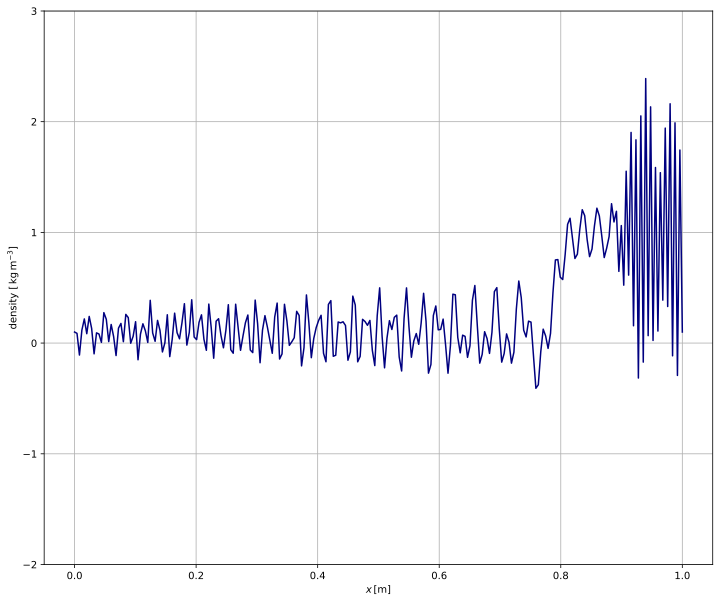

In [4]:
ims = []
fig = plt.figure(figsize=[12,10])
plt.grid()

for i in range(len(save_arr)):
    im = plt.plot(x_arr, save_arr[i], color='navy', animated=True)
    plt.xlabel('$x \,[\mathrm{m}]$')
    plt.ylabel('density [$\,\mathrm{kg} \, \mathrm{m}^{-3}$]')
    plt.ylim(-2,3)
    ims.append(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=100)
ani.save('haynes_HW4_P1a.mp4')

## NOTE:: John and I were not able to reconcile the MP4 videos playing in the notebook for me (working on a linux desktop machine) so he granted me permission to submit MP4 files separately

#### (b) FTUS (Forward-time, Upwind-spatial) Integration method
We now proceed with the upwind scheme, where the discretized advection equation is rewritten as:
$$ q_i^{n+1} = q_i^{n} - \frac{c \mathrm{d}t}{\mathrm{d}x} (q^n_{i} - q^n_{i-1}) \qquad .$$

In [ ]:
# initialize time and spatial meshes
xminB = 0.
xmaxB = 1.
NpointsB = 250

tmaxB = 0.5
dtB = 1.e-04
ntB = tmaxB / dtB

NoutputsB = 14
output_everyB = int(ntB / NoutputsB)


# initialize spatial grid 
x_arrB = np.linspace(start=xminB,stop=xmaxB,num=NpointsB)
dxB = x_arrB[2] - x_arrB[1]

color_arr = ['#37AB65', '#3DF735', '#AD6D70', '#EC2504', '#8C0B90', '#C0E4FF', '#27B502', '#7C60A8', '#CF95D7', '#FF9900']

# define wave speed
cB = 1.

cfl_factorB = cB * dtB / dxB

# define function to advance density array
def advance_FTUS(q_arr, cfl_factorB):
    N = len(q_arr)
    ret_arr = np.zeros_like(q_arr)
    ret_arr[:] = q_arr[:] - (cfl_factorB) * ( q_arr[:] - np.roll(q_arr,1) )
    return ret_arr



# initialize density profile
q0B = init_advec1D(x_arr)
q_nB = q0B
q_np1B = np.zeros_like(q_n)

print('CFL factor = '+str(cfl_factor))


# initialize time markers for loop
timeB = 0.
time_idxB=0
tickerB = 0

sols_saveB = []

while time_idxB <= ntB:
    # numerical scheme
    q_np1B = advance_FTUS(q_nB, cfl_factorB)

    # conditionally store outputs, sequentially
    if time_idxB % output_everyB == 0:
        sols_saveB.append(q_np1B)
    
    # advance quantity
    q_nB = q_np1B.copy()
    q_np1B = np.zeros_like(q_nB)
    # advance time
    timeB += dtB
    time_idxB += 1

## NOTE:: [please see note above]: As discussed with the instructor, I am unable to provide animations that play in the notebook itself from my machine, but I produce some fixed plots for reference, and the animations are produced / saved but not shown here

In [ ]:

for i in range(NoutputsB):
    teq = 't = '
    timei = dtB * i *  output_everyB
    lab = teq + str(round(timei,3)) + ' s'
    plt.plot(x_arrB, sols_saveB[i], color=color_arr[i % len(color_arr)],linewidth=1.8,label=lab)

plt.grid()
plt.legend()
plt.show()

We now compute the solution with the specified timing parameters:

In [ ]:
# initialize time and spatial meshes
xminB = 0.
xmaxB = 1.
NpointsB = 250
tmaxB = 2.
dtB = 1.e-03
ntB = int(tmaxB / dtB)
NoutputsB = 8
output_everyB = int(0.02*ntB)

# initialize spatial grid 
x_arrB = np.linspace(start=xminB,stop=xmaxB,num=NpointsB)
dxB = x_arrB[2] - x_arrB[1]
# define wave speed
cB = 1.
cfl_factorB = cB * dtB / dxB

# initialize density profile
q0B = init_advec1D(x_arr)
q_nB = q0B
q_np1B = np.zeros_like(q_n)
print('CFL factor = '+str(cfl_factorB))
# initialize time markers for loop
timeB = 0.
time_idxB=0
tickerB = 0

sols_saveB = []

while time_idxB <= ntB:
    # numerical scheme
    q_np1B = advance_FTUS(q_nB, cfl_factorB)

    # conditionally store outputs, sequentially
    if time_idxB % output_everyB == 0:
        sols_saveB.append(q_np1B)
    
    # advance quantity
    q_nB = q_np1B.copy()
    q_np1B = np.zeros_like(q_nB)
    # advance time
    timeB += dtB
    time_idxB += 1


In [ ]:
ims = []
fig = plt.figure(figsize=[12,10])
plt.grid()

for i in range(len(sols_saveB)):
    im = plt.plot(x_arr, sols_saveB[i], color='navy', animated=True)
    plt.xlabel('$x \,[\mathrm{m}]$')
    plt.ylabel('density [$\,\mathrm{kg} \, \mathrm{m}^{-3}$]')
    plt.ylim(-1,2)
    ims.append(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=100)
ani.save('haynes_HW4_P1b.mp4')

## NOTE:: John and I were not able to reconcile the MP4 videos playing in the notebook for me (working on a linux desktop machine) so he granted me permission to submit MP4 files separately

Looks like we can evolve this wave for multiple periods! It is evident that the wave profile is approaching the shape of a Gaussian-bell like distribution from the square wave that was initialized. This is the result of numerical diffusion.  

## Problem 2
### Two-dimensional advection
We now seek to extend the solution obtained in problem 1(b) to a 2D spatial grid. 

In [ ]:
# initialize time and spatial meshes
xm = ym = 0.
xM = yM = 1.

Nx = Ny = 128

tmax2 = 1.
dt2 = 1.e-03

nt2 = tmax2 / dt2

Noutputs2 = 50
output_every2 = int(nt2 / Noutputs2)


# initialize spatial grid 
x_arr2 = np.linspace(start=xm,stop=xM,num=Nx)
y_arr2 = np.linspace(start=ym,stop=yM,num=Ny)

xgrid, ygrid = np.meshgrid(x_arr2, y_arr2)

dx2 = dy2 = x_arr2[1] - x_arr[0]


# define wave speed (VECTOR THIS TIME!)
cvec = np.array([1.,1.])

    
cfl_factorX = cvec[0] * dt2 / dx2
cfl_factorY = cvec[1] * dt2 / dy2

print(cfl_factorX,cfl_factorY)


# define function to advance density array
def advance_FTUS_2D(qxy_arr, cfl_factorX, cfl_factorY):
    N = len(qxy_arr[:,1])
    ret_arr = np.zeros_like(qxy_arr)
    # untested
    ret_arr = qxy_arr - (cfl_factorX) * ( qxy_arr[:,:] - np.roll(qxy_arr,1,axis=0) ) - (cfl_factorY) * ( qxy_arr[:,:] - np.roll(qxy_arr,1,axis=1) )
    return ret_arr

def init_advec2D(xgrid, ygrid):
    return np.sin(2. * np.pi * xgrid) + np.cos(2. * np.pi * ygrid)

# initialize density profile
a = init_advec2D(xgrid, ygrid)
# plot to verify
plt.imshow(a, extent=[0.,1.,0.,1.])
plt.xlabel('$x \,[\mathrm{m}]$')
plt.ylabel('$y \,[\mathrm{m}]$')
plt.title('Initial condition')
plt.show()


# init arrays to hold solutions
q20 = a
q2n = q20.copy()
q2np1 = np.zeros_like(q2n)



# initialize timers for loop
time2 = 0.
time2_idx = int(0)
# initialize storage array
sols_save2 = []

# numerical solver
while time2_idx < nt2:
    # finite differencing scheme
    q2np1 = advance_FTUS_2D(q2n, cfl_factorX, cfl_factorY)

    # conditionally store outputs, sequentially
    if time2_idx % output_every2 == 0:
        sols_save2.append(q2np1)

    # advance time
    time2 += dt2
    time2_idx +=1
    
    q2n = q2np1.copy()
    q2np1 = np.zeros_like(q2n)
    
plt.imshow(q2n, extent=[0.,1.,0.,1.])
plt.xlabel('$x \,[\mathrm{m}]$')
plt.ylabel('$y \,[\mathrm{m}]$')
plt.title('Final state ($t=$ '+str(round(time2,3))+')')



In [ ]:
ims = []
fig = plt.figure(figsize=[12,10])

## NOTE:: John and I were not able to reconcile the MP4 videos playing in the notebook for me (working on a linux desktop machine) so he granted me permission to submit MP4 files separately
## NOTE 2: the prompt for problem 2 specifies BOTH a grid mesh size (i.e., N=64 points in both dimensions) as well as a timestep of 1 us. However, the prompt also asks for Courant number of 0.5: since these are inherently inconsistent,
## we elect to increase the grid resolution by a factor of two (i.e., N=128 in both dimensions) to bring the Courant number closer to 0.5 (\approx 0.125), but we do not increase it beyond this to avoid longer runtimes.


for i in range(Noutputs2):
    im = plt.imshow(np.flip(sols_save2[i],axis=0), extent=[0.,1.,0.,1.])
    #plt.colorbar(label='density [$\,\mathrm{kg} \, \mathrm{m}^{-3}$]')
    #plt.title('time $t=$ '+str(round(i*(time2/Noutputs2),3)))
    plt.xlabel('$x \,[\mathrm{m}]$')
    plt.ylabel('$y \,[\mathrm{m}]$')
    
    ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=100)
ani.save('haynes_HW4_P2.mp4')

## Problem 3
### Application question:


Numerical artifacts were prevalent in the FTCS scheme, since it is unconditionally unstable for all choices of spatial and temporal step sizes. These artifacts can only be avoided by the choice of a more appropriate scheme, one that is (un)conditionally stable, as was demonstrated by the solutions for Problem 1(a) and 1(b). However, the solutions obtained with the FTUS method are _not_ exactly representative of the advection process in isolation, either: the finite differencing scheme used for the advection equation introduces a diffusion term when truncated at first order: 
$$ q_i^{n+1} = q_i^{n} - \frac{c \mathrm{d}t}{\mathrm{d}x} (q^n_{i} - q^n_{i-1}) \qquad $$
follows from the expression for the first spatial derivative:
$$ \partial_x u = \frac{q_i^{n} - q_{i-1}^n}{\mathrm{d}x} - \frac{1}{2} \partial_x^2 q^n(\mathrm{d}x) + \dots \qquad .$$
Since the upwind (as well as downwind (FTDS) or central differencing (FTCS)) scheme truncates this expression after the first order term, the negative term including the second derivative acts as an articficial diffusion process. 

This numerical diffusion is a critical artifact that must be addressed when attempting to solve a system of PDEs in multiple spatial dimensions, e.g., the radiative MHD equations for an accretion disk, or the Navier-Stokes equation and stress balance for fluid flow. Since diffusion itself is a physical process, it must be carefully combated. This is done so by constructing a numerical scheme that _includes_ such a term to oppose the one introduced by the finite differencing. This method is the Crank-Nicolson technique, which is an implicit, 2nd order time method that is unconditionally stable for advection/diffusion processes. This method represents a clever combination of the explicit Euler-Forward and implicit Euler-Backward methods (it is _not_ simply the average of the two!). This method is frequently employed in applications of first and second order systems of PDEs, and the method lends itself well to linearization in the case of a nonlinear PDE. For the advection/diffusion equation, the method results in a tri-diagonal matrix being solved at each timestep. This is advantageous, because in contrast to other implicit methods which require the _inversion_ of a $m\times m$ matrix for spatial mesh node count $m$ (an $\mathcal{O}(m^3)$ process), the Thomas Algorithm can be employed to make the algabraic equations at each step require _only_  $\mathcal{O}(m)$ complexity!